<a href="https://colab.research.google.com/github/dyna-bytes/PyTorchIntensive/blob/main/6_1_2_Convolutional_Auto_Encoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%%capture
!pip install pytorch_lightning torchinfo torchmetrics torchviz

In [ ]:
# 변수의 shape, type, value 확인
def p(var,_str='') :
    if _str=='\n' or _str=='cr' :
        _str = '\n'
    else :
        print(f'[{_str}]:')
        _str = ''
    if type(var)!=type([]):
        try:
            print(f'Shape:{var.shape}')
        except :
            pass
    print(f'Type: {type(var)}')
    print(f'Values: {var}'+_str)

def pst(_x,_name=""):
    print(f'[{_name}] Shape{_x.shape}, {type(_x)}')
def ps(_x,_name=""):
    print(f'[{_name}] Shape{_x.shape}')

# **실습:  Convolutional Auto Encoder**


## **Import Module**

In [ ]:
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, random_split
import pytorch_lightning as pl
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import ModelCheckpoint
from torchmetrics import functional as FM
from torchinfo import summary
from torch.utils.data import Dataset, DataLoader
from pytorch_lightning.loggers import CSVLogger
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
plt.rcParams['figure.figsize'] = [5, 3.5]

device='cuda:0'
torch.__version__

'2.0.1+cu118'

## **DataSet**

### Options

In [ ]:
#options
#select dataset : fashion_mnist or mnist
#fashion_mnist_on = True     #Fashion MNIST
fashion_mnist_on = False   # MNIST

#select noise on/off : on 시 denoising
noise_on = True            # DAE
#noise_on = False            # AE

### Load

### Preprocessing

In [ ]:
import torchvision.transforms as transforms
from torchvision.datasets import FashionMNIST, MNIST

class AddNoise(object):
    def __init__(self, noise_rate=0.1):
        self.noise_rate=noise_rate
    def __call__(self, sample):
        image = sample.reshape(sample.shape[0], -1)
        image += self.noise_rate*np.random.randn(image.shape[0], 784)
        # float으로 변환해주어야 함!
        return image.reshape(sample.shape).float()

# Normalize data with mean=0.5, std=1.0
mnist_transform = transforms.Compose([
                            transforms.ToTensor(),
                            AddNoise()]) # noise add

# download path 정의
if fashion_mnist_on:
    download_root = './FashionMNIST_DATASET'
    train_dataset = FashionMNIST(download_root, transform=mnist_transform, train=True, download=True)
    test_dataset = FashionMNIST(download_root, transform=mnist_transform, train=False, download=True)
else:
    download_root = './MNIST_DATASET'
    train_dataset = MNIST(download_root, transform=mnist_transform, train=True, download=True)
    test_dataset = MNIST(download_root, transform=mnist_transform, train=False, download=True)

trainDataLoader = DataLoader(train_dataset, batch_size=512)
testDataLoader = DataLoader(test_dataset, batch_size=512)

In [ ]:
# Print out the shape
ps(train_dataset[0][0])
p(train_dataset[0][1])

[] Shapetorch.Size([1, 28, 28])
[]:
Type: <class 'int'>
Values: 5


## **Model**

### Define

In [ ]:
# AE4 model
class AE4(pl.LightningModule):
    def __init__(self):
        super(AE4, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 16, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.BatchNorm2d(16),
            nn.Conv2d(16, 8, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, padding=1) )

        self.decoder = nn.Sequential(
            nn.Conv2d(8, 8, 3, padding=1),
            nn.ReLU(),
            nn.Upsample((8,8)),
            nn.Conv2d(8, 16, 3, padding=1),
            nn.ReLU(),
            nn.Upsample((16,16)),
            nn.BatchNorm2d(16),
            nn.Conv2d(16, 32, 3, padding=0),
            nn.ReLU(),
            nn.Upsample((28,28)),
            nn.Conv2d(32, 1, 3, padding=1),
            nn.Sigmoid() )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

    def training_step(self, batch, batch_idx):
        x, _ = batch
        decoded = self(x.float())
        loss_mse = F.mse_loss(decoded, x)
        metrics={'loss':loss_mse}
        self.log_dict(metrics,prog_bar=True)
        return metrics

    def validation_step(self, batch, batch_idx):
        x, _ = batch
        decoded = self(x.float())
        loss_mse = F.mse_loss(decoded, x)
        metrics={'val_loss':loss_mse}
        self.log_dict(metrics,prog_bar=True)

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters())

ae4 = AE4().to(device)
summary(ae4, input_size=(8, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
AE4                                      [8, 1, 28, 28]            --
├─Sequential: 1-1                        [8, 8, 4, 4]              --
│    └─Conv2d: 2-1                       [8, 32, 28, 28]           320
│    └─ReLU: 2-2                         [8, 32, 28, 28]           --
│    └─MaxPool2d: 2-3                    [8, 32, 14, 14]           --
│    └─Conv2d: 2-4                       [8, 16, 14, 14]           4,624
│    └─ReLU: 2-5                         [8, 16, 14, 14]           --
│    └─MaxPool2d: 2-6                    [8, 16, 7, 7]             --
│    └─BatchNorm2d: 2-7                  [8, 16, 7, 7]             32
│    └─Conv2d: 2-8                       [8, 8, 7, 7]              1,160
│    └─ReLU: 2-9                         [8, 8, 7, 7]              --
│    └─MaxPool2d: 2-10                   [8, 8, 4, 4]              --
├─Sequential: 1-2                        [8, 1, 28, 28]            --
│    └─C

In [ ]:
#torch.onnx.export(ae4, torch.zeros((8, 1, 28, 28)).to(device), 'DeepConvAE.onnx')

### Fit

Epoch 10/10
60000/60000 [==============================] - 6s 106us/sample - loss: 0.0275 - val_loss: 0.0274
CPU times: user 52.4 s, sys: 9.23 s, total: 1min 1s

Wall time: 1min (@Notebook Setting/GPU)

In [ ]:
%%time
ae4 = AE4()

logger = CSVLogger("logs", name="AE4")
trainer = Trainer(max_epochs=30, logger=logger, accelerator='auto',
                  limit_train_batches=0.5,limit_val_batches=0.5)
trainer.fit(ae4, trainDataLoader, testDataLoader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name    | Type       | Params
---------------------------------------
0 | encoder | Sequential | 6.1 K 
1 | decoder | Sequential | 6.7 K 
---------------------------------------
12.8 K    Trainable params
0         Non-trainable params
12.8 K    Total params
0.051     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=30` reached.


CPU times: user 8min 10s, sys: 2.02 s, total: 8min 12s
Wall time: 8min 25s


Wall time: 8min 25s

In [ ]:
# model train_logdir 확인
v_num = ae4.logger.version
log_dir = f'logs/AE4/version_{v_num}'
metrics = pd.read_csv(os.path.join(log_dir, 'metrics.csv'))

In [ ]:
metric_df = metrics.groupby('epoch').mean()[['loss', 'val_loss']]

plt.title('Loss')
plt.plot(metric_df['loss'], 'b', label='train_loss')
plt.plot(metric_df['val_loss'], 'g', label='val_loss')
#plt.ylim([0,0.5])
plt.grid(True)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='best')
plt.show()

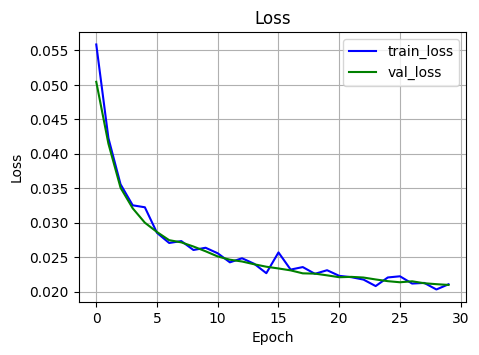

### Predict

In [ ]:
# Input image
ps(test_dataset[0][0].unsqueeze(dim=0)) #(bs,ch,28,28)

[] Shapetorch.Size([1, 1, 28, 28])


In [ ]:
# Decoded image
ps(ae4(test_dataset[0][0].unsqueeze(dim=0)))

[] Shapetorch.Size([1, 1, 28, 28])


In [ ]:
# Predict
decoded_imgs = []
for i in range(9):
    decoded_imgs.append(ae4(test_dataset[i][0].unsqueeze(dim=0)))

ps(decoded_imgs[1])

[] Shapetorch.Size([1, 1, 28, 28])


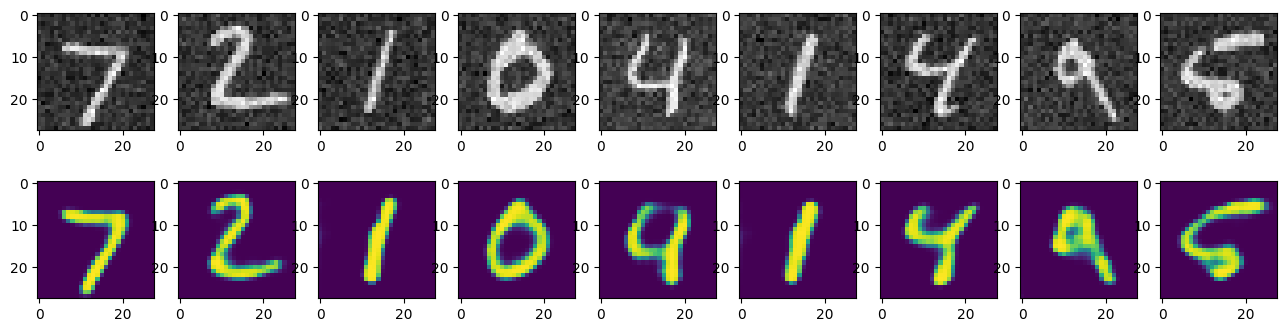

In [ ]:
plt.figure(figsize=(16, 4))
num_imgs = 9
for i in range(num_imgs):
    # display original
    ax = plt.subplot(2, num_imgs, i + 1)
    true_img = test_dataset[i][0].reshape(28, 28)
    plt.imshow(true_img, cmap='gray')

    # display reconstruction
    ax = plt.subplot(2, num_imgs, i + 1 + num_imgs)
    reconstructed_img = decoded_imgs[i].reshape(28,28)
    plt.imshow(reconstructed_img.detach().numpy())
plt.show()

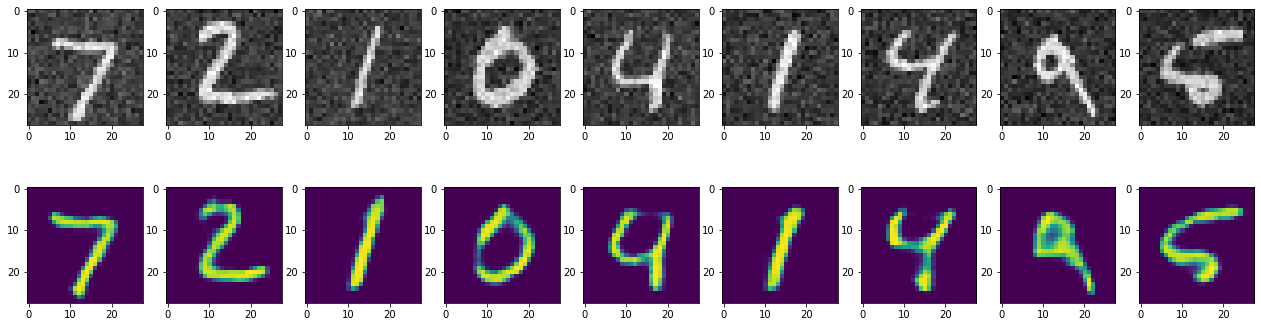

## **Analysis**

### Plot

## **실습 과제**

### 과제 1. Data set을 바꾸고 noise가 추가 되는 경우 결과가 얼마나 다른지 확인하자
#### -- FashionMNIST를읽고, "noise_on = False" 를 "True"로 변경
#### -- Noisy data로 다시 학습하여 결과를 확인하자
#### -- 결과 이미지의 차이를 비교해 보자


### 과제 2. just fitting을 위해 Batch_size와 Epoch를 최적화 해보자
#### -- 최적화 이전의 Decoded영상과 최적화 이후 영상을 비교해 보자
#### -- 최적 값은 얼마인가, 최저의 val_loss 값을 적자 :
#### -- 두개의 영상을 첨부하자

